<a href="https://colab.research.google.com/github/dinun0427/OOP_Course_Work/blob/master/YellowB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install split-folders

In [ ]:
import splitfolders

#set the directory
input_file = '/content/drive/MyDrive/YellowB/Dataset_Raw'
output_file = '/content/drive/MyDrive/YellowB/Dataset_Raw_Split'

splitfolders.ratio(input_file, output_file, seed=42, ratio=(0.8, 0.1, 0.1), group_prefix=None)

Copying files: 2000 files [00:55, 36.31 files/s]


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

In [ ]:
# Advanced Data Augmentation
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Use VGG16 preprocessing
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'  # More sophisticated fill mode
)

In [ ]:
# Load the VGG16 model with pre-trained weights, without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Make the base model trainable for fine-tuning
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [ ]:
# New Model Architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Assuming 6 classes
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Hyperparameters
batch_size = 32  # Consider tuning
epochs = 50  # Consider tuning

In [ ]:
# Fit Model with Augmented Data
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/YellowB/Dataset_Raw_Split/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/YellowB/Dataset_Raw_Split/val',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 1600 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


In [ ]:
# Define ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/YellowB/YellowB.tflite',  # Specify the path to save your model
    monitor='val_loss',  # Monitor the validation loss
    save_best_only=True,  # Only save the model if `val_loss` has improved
    save_weights_only=False,  # Save the whole model, not just the weights
    verbose=1  # Log a message when a better model is saved
)

In [ ]:
# Include the callback in the model.fit call
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        model_checkpoint_callback  # Use the ModelCheckpoint callback
    ]
)

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.7594 
Epoch 1: val_loss improved from inf to 0.40916, saving model to /content/drive/MyDrive/YellowB/YellowB.tflite
50/50 [==============================] - 840s 17s/step - loss: 0.7090 - accuracy: 0.7594 - val_loss: 0.4092 - val_accuracy: 0.8646
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.2175 - accuracy: 0.9300 
Epoch 2: val_loss improved from 0.40916 to 0.18406, saving model to /content/drive/MyDrive/YellowB/YellowB.tflite
50/50 [==============================] - 841s 17s/step - loss: 0.2175 - accuracy: 0.9300 - val_loss: 0.1841 - val_accuracy: 0.9531
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.9581 
Epoch 3: val_loss improved from 0.18406 to 0.13089, saving model to /content/drive/MyDrive/YellowB/YellowB.tflite
50/50 [==============================] - 834s 17s/step - loss: 0.1322 - accuracy: 0.9581 - val_loss: 0.1309 - val_a

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/drive/MyDrive/YellowB/YellowB.tflite')

# Assuming class names are defined as follows; adjust according to your dataset
class_names = {0: 'Black Sigatoka   ',1: 'Cordana          ', 2: 'Fusarium Wilt    ', 3: 'Healthy          ', 4: 'Pestalotiopsis   '}

def test_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_expanded_dims)

    # Predict the class
    prediction = model.predict(img_preprocessed)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = class_names[predicted_class_index]

    # Print the predicted class name and its confidence
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {np.max(prediction)*100:.2f}%")

    # Optionally, print all class confidences
    print("\nConfidence scores for all classes:")
    for i, score in enumerate(prediction[0]):
        print(f"{class_names[i]}: {score*100:.2f}%")


# Example usage
test_image('/content/drive/MyDrive/YellowB/Dataset_Raw_Split/test/Fusarium Wilt/Image_3583.jpg')

1/1 [==============================] - 1s 893ms/step
Predicted class: Fusarium Wilt    
Confidence: 99.97%

Confidence scores for all classes:
Black Sigatoka   : 0.02%
Cordana          : 0.00%
Fusarium Wilt    : 99.97%
Healthy          : 0.01%
Pestalotiopsis   : 0.00%


In [ ]:
def evaluate_model_on_test_dataset(model_path, test_data_dir):
    """
    Evaluate the model on the test dataset.

    Parameters:
    - model_path: str, path to the trained model file.
    - test_data_dir: str, path to the directory containing test data.

    Returns:
    - test_accuracy: float, accuracy of the model on the test dataset.
    """

    # Load the trained model
    model = load_model(model_path)

    # No need to use data augmentation on test data
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Create a test generator
    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(224, 224),
        batch_size=batch_size,  # Use the same batch size as in training
        class_mode='categorical',
        shuffle=False  # No need to shuffle test data
    )

    # Evaluate the model on the test dataset
    results = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

    # Results contain loss and accuracy. We're interested in accuracy.
    test_accuracy = results[1]  # assuming that model.metrics_names[1] == 'accuracy'
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")

    return test_accuracy

# Example usage
model_path = '/content/drive/MyDrive/YellowB/YellowB.tflite'
test_data_dir = '/content/drive/MyDrive/YellowB/Dataset_Raw_Split/test'
evaluate_model_on_test_dataset(model_path, test_data_dir)

Found 200 images belonging to 5 classes.
6/6 [==============================] - 125s 21s/step - loss: 0.0085 - accuracy: 1.0000
Test Accuracy: 100.00%


1.0

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

test_generator = ImageDataGenerator().flow_from_directory(
    '/content/drive/MyDrive/YellowB/Dataset_Raw_Split/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Generate predictions for the entire test dataset
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve true labels
true_classes = test_generator.classes

# Calculate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Print the metrics
print(f'Accuracy : {accuracy}')
print(f'Precision: {precision}')
print(f'Recall   : {recall}')
print(f'F1 Score : {f1}')

# Detailed classification report
print(classification_report(true_classes, predicted_classes))

Found 200 images belonging to 5 classes.
7/7 [==============================] - 131s 19s/step
Accuracy : 0.85
Precision: 0.8807860940265121
Recall   : 0.85
F1 Score : 0.8382001645132351
              precision    recall  f1-score   support

           0       0.95      0.88      0.91        40
           1       1.00      0.45      0.62        40
           2       0.73      1.00      0.84        40
           3       0.98      1.00      0.99        40
           4       0.76      0.93      0.83        40

    accuracy                           0.85       200
   macro avg       0.88      0.85      0.84       200
weighted avg       0.88      0.85      0.84       200



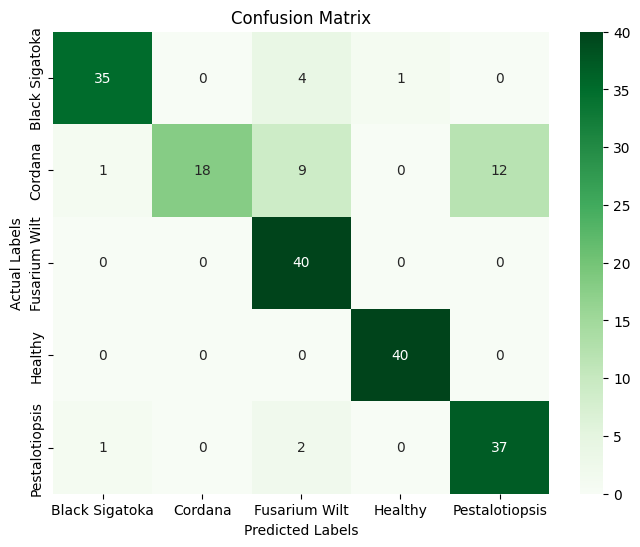

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

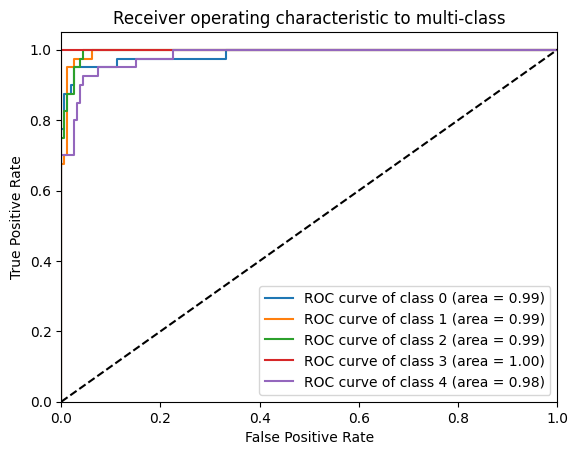

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Compute ROC curve and AUC for each class
n_classes = test_generator.num_classes
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Note: The actual implementation will require the actual test data and model predictions.
# The above code will not run here because we don't have the actual test data and model files.

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=fb0e833fd7583161aca1f0a04d1b8a392bcaccead12c67db8376961e12923e27
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


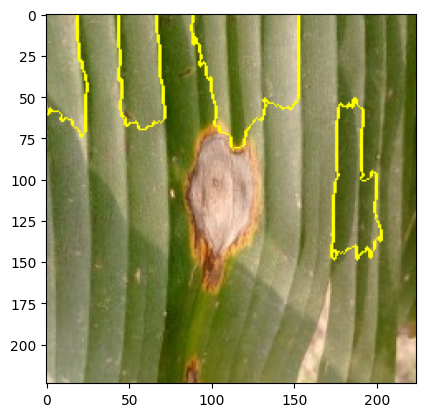

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image as keras_image  # Rename to avoid conflict

# Assuming other necessary imports are done earlier in your notebook

def predict_fn(images):
    # Preprocess the images to the format your model expects
    images = np.array([preprocess_input(img.astype('float32')) for img in images])
    # Predict
    return model.predict(images)

# Create a LIME explainer object
explainer = lime_image.LimeImageExplainer()

# Choose an image to explain
img_path = '/content/drive/MyDrive/YellowB/Dataset_Raw_Split/test/Cordana/210.jpeg'
image = keras_image.load_img(img_path, target_size=(224, 224))
image = keras_image.img_to_array(image).astype('double')
image /= 255.0  # Normalize the image

# Explain the prediction
explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

# Display the image and the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.show()